# GloVe Classifier

This is a version of the News Classifier that uses GloVe vectors for classification. GloVe vectors were downloaded from [here](https://nlp.stanford.edu/projects/glove/). The vectors are stored in the `data` folder of this repo, which is not commited to source code.

We implement two models in this notebook: the first uses a simple averaging of word vectors while the other uses a TF-IDF weighting of word vectors.

The weighted / non-weighted averaging of word embeddings is then passed into a logistic regression model for class prediction.

**Note: There are some random processes within this notebook, so different runs of the notebook may result in different outcomes.**

**Note: This notebook assumes the data being loaded has already been randomly shuffled.**

In [1]:
    import data_utils
    import math
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import torch

    from data_utils import WordEmbeddingEncoding, WordTokenDataset
    from time import time
    from torch.utils.data import DataLoader


## Load and Setup the Data


In [2]:
embeddings = data_utils.load_embeddings('./data/glove.6B/glove.6B.100d.txt',
                                        embedding_dim=100)


In [3]:
data = pd.read_json('./data/train_data.json', orient='records')


In [4]:
train_test_split = 0.95
split_idx = math.floor(len(data) * train_test_split)

train_data = data.iloc[0:split_idx]
valid_data = data.iloc[split_idx:]

In [5]:
encoding = WordEmbeddingEncoding(data, embeddings)
encoding.prepare()


In [6]:
train_dataset = WordTokenDataset(train_data, encoding)
train_dataset.prepare()


In [7]:
valid_dataset = WordTokenDataset(valid_data, encoding)
valid_dataset.prepare()


## Hyperparameter Configurations

In [8]:
# Doing a basic hyper-parameter grid search.

hyperparams_list = [
    { 'weighting': 'uniform', 'lr': 0.001,  'batch_size': 100 },
    { 'weighting': 'uniform', 'lr': 0.01,   'batch_size': 100 },
    { 'weighting': 'uniform', 'lr': 0.001,  'batch_size': 10  },
    { 'weighting': 'uniform', 'lr': 0.01,   'batch_size': 10  },
    { 'weighting': 'tf_idf',  'lr': 0.001,  'batch_size': 100 },
    { 'weighting': 'tf_idf',  'lr': 0.01,   'batch_size': 100 },
    { 'weighting': 'tf_idf',  'lr': 0.001,  'batch_size': 10  },
    { 'weighting': 'tf_idf',  'lr': 0.01,   'batch_size': 10  },
]


## Create the Model

In [9]:
class Model(torch.nn.Module):
    def __init__(self, embeddings, n_classes, weighting):
        super(Model, self).__init__()

        self.weighting = weighting

        torch_embeddings = torch.FloatTensor(embeddings.values)
        self.embedding_bag = torch.nn.EmbeddingBag.from_pretrained(torch_embeddings, mode='sum')
        self.linear = torch.nn.Linear(self.embedding_bag.embedding_dim, n_classes)


    def forward(self, samples):
        if weighting == 'tf_idf':
            weights = samples.create_tf_idf_weights()
        else:
            weights = samples.create_uniform_weights()

        x = self.embedding_bag(samples.sequence, samples.offset, per_sample_weights=weights)
        output = self.linear(x)
        return output


    def predict(self, samples):
        with torch.no_grad():
            outputs = self(samples)
            predictions = torch.argmax(outputs, axis=1)

        return predictions



## Training the Model

In [10]:
def train(model, criterion, optimizer, dataset, data_loader, epochs, log=True):
    train_losses = []
    print_every = 1

    for epoch in range(epochs):
        losses = []

        for i, samples in enumerate(data_loader):
            optimizer.zero_grad()
            output = model(samples)
            loss = criterion(output, samples.label)
            loss.backward()
            optimizer.step()

            losses.append(loss)

        train_loss = torch.mean(torch.stack(losses))
        train_losses.append(train_loss)

        if log and (epoch + 1) % print_every == 0:
            train_loss_estimator_start = max(1, len(dataset) - train_loss_estimator_size)
            random_start = torch.randint(high=train_loss_estimator_start, size=(1,)).item()

            samples = dataset[random_start:(random_start+train_loss_estimator_size)]
            predictions = model.predict(samples)
            labels = samples.label

            total = len(labels)
            correct = torch.sum(labels == predictions)

            print(f'Epoch {epoch + 1}')
            print(f'Accuracy: {float(correct)/total*100:.02f}%.')
            print(f'Training Loss: {train_loss.item()}')
            print()
        
    return train_losses
    

In [11]:
epochs = 5

models = []
train_losses_list = []
valid_losses = []

accepted_tokens = {t for t in embeddings.index}

for i, hyperparams in enumerate(hyperparams_list):
    print(f'Starting training Model {i+1} / {len(hyperparams_list)}...')

    start_time = time()

    batch_size = hyperparams['batch_size']
    lr = hyperparams['lr']
    weighting = hyperparams['weighting']

    # 1. Setup Data Loader

    data_loader = DataLoader(dataset=train_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             collate_fn=data_utils.collate_samples)

    # 2. Create the Model

    model = Model(embeddings=embeddings,
                  n_classes=encoding.n_classes(),
                  weighting=weighting)

    # 3. Setup Criterion and Optimizer

    criterion = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 4. Train the Model

    train_losses = train(model,
                         criterion,
                         optimizer,
                         train_dataset,
                         data_loader,
                         epochs)
    
    # 5. Calculate Validation Loss
    
    with torch.no_grad():
        valid_samples = valid_dataset[:]

        outputs = model(valid_samples)

        valid_loss = criterion(outputs, valid_samples.label)
        valid_losses.append(valid_loss)

    end_time = time()

    models.append(model)
    train_losses_list.append(train_losses)

    print(f'Model completed in {(end_time - start_time)/60:.02f}m.')
    print()


Starting training Model 1 / 2...
Epoch 1, Batch 1
Epoch 1
Accuracy: 16.30%.
Training Loss: 1.6778786182403564

Epoch 2, Batch 1
Epoch 2
Accuracy: 63.30%.
Training Loss: 1.5192432403564453

Epoch 3, Batch 1
Epoch 3
Accuracy: 62.10%.
Training Loss: 1.4922223091125488

Epoch 4, Batch 1
Epoch 4
Accuracy: 70.90%.
Training Loss: 1.4811617136001587

Epoch 5, Batch 1
Epoch 5
Accuracy: 15.20%.
Training Loss: 1.4746885299682617

Model completed in 14.31m.

Starting training Model 2 / 2...
Epoch 1, Batch 1
Epoch 1
Accuracy: 62.80%.
Training Loss: 1.5891660451889038

Epoch 2, Batch 1
Epoch 2
Accuracy: 12.20%.
Training Loss: 1.4812233448028564

Epoch 3, Batch 1
Epoch 3
Accuracy: 62.00%.
Training Loss: 1.4666342735290527

Epoch 4, Batch 1
Epoch 4
Accuracy: 11.00%.
Training Loss: 1.461546778678894

Epoch 5, Batch 1
Epoch 5
Accuracy: 12.90%.
Training Loss: 1.458885908126831

Model completed in 19.74m.



## Check Results

In [13]:
uniform_mask = [hp['weighting'] == 'uniform' for hp in hyperparams_list]

uniform_models = [m for i, m in enumerate(models) if uniform_mask[i]]
uniform_train_losses_list = [losses for i, losses in enumerate(train_losses_list) if uniform_mask[i]]
uniform_valid_losses = [loss.item() for i, loss in enumerate(valid_losses) if uniform_mask[i]]

tf_idf_models = [m for i, m in enumerate(models) if not uniform_mask[i]]
tf_idf_train_losses_list = [losses for i, losses in enumerate(train_losses_list) if not uniform_mask[i]]
tf_idf_valid_losses = [loss.item() for i, loss in enumerate(valid_losses) if not uniform_mask[i]]


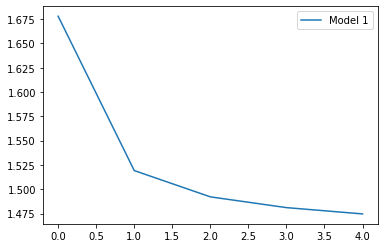

In [14]:
# Training loss of uniform models.

for i, model in enumerate(uniform_models):
    train_losses = uniform_train_losses_list[i]
    plt.plot(train_losses)

plt.legend([f'Model {i+1}' for i in range(len(uniform_models))])
plt.show()


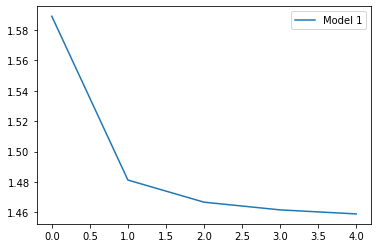

In [15]:
# Training loss of tf-idf models.

for i, model in enumerate(tf_idf_models):
    train_losses = tf_idf_train_losses_list[i]
    plt.plot(train_losses)

plt.legend([f'Model {i+1}' for i in range(len(tf_idf_models))])
plt.show()


### Find the Best Models

We will grab the "best" model trained on uniform weights and tf-idf weights. This will be based on which model scores the lowest validation loss.

In [17]:
# Grab the best models.

best_uniform_model_idx = uniform_valid_losses.index(min(uniform_valid_losses))
best_uniform_model = uniform_models[best_uniform_model_idx]

best_tf_idf_model_idx = tf_idf_valid_losses.index(min(tf_idf_valid_losses))
best_tf_idf_model = tf_idf_models[best_tf_idf_model_idx]

print(f'Best Uniform Model: {best_uniform_model_idx+1}')
print(f'Best TF-IDF Model:  {best_tf_idf_model_idx+1}')


Best Uniform Model: 1
Best TF-IDF Model:  1


### Accuracy

In [20]:
valid_samples = valid_dataset[:]

In [21]:
uniform_predictions = best_uniform_model.predict(valid_samples)

total = len(valid_samples.label)
correct = torch.sum(uniform_predictions == valid_samples.label)
accuracy = float(correct) / total

print(f'Accuracy of Uniform Model: {(accuracy*100:.02f}%.')


Accuracy of Uniform Model: 65.74%.


In [25]:
tf_idf_predictions = best_tf_idf_model.predict(valid_samples)

total = len(valid_samples.label)
correct = torch.sum(tf_idf_predictions == valid_samples.label)
accuracy = float(correct) / total

print(f'Accuracy of TF-IDF Model: {(accuracy*100:.02f}%.')


Accuracy of TF-IDF Model: 67.47%.


### Confusion Matrix

In [26]:
def create_confusion_matrix(labels, predictions):
    # Displaying a confusion matrix of the validation results for our model.

    categories = labels.unique()
    category_encoder = { c.item():i for i,c in enumerate(categories) }

    confusion_matrix = np.random.rand(len(categories), len(categories))

    for i, category in enumerate(categories):
        row = np.zeros(len(categories))

        cat_mask = (labels == category.item()).tolist()
        cat_preds = predictions[cat_mask]
        
        for category in categories:
            pred_count = torch.sum(cat_preds == category.item())
            row[category_encoder[category.item()]] = pred_count
            
        confusion_matrix[i, :] = row / len(cat_preds)

    return confusion_matrix, category_encoder


In [27]:
def show_confusion_matrix(confusion_matrix):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    cax = ax.matshow(confusion_matrix)

    fig.colorbar(cax)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    

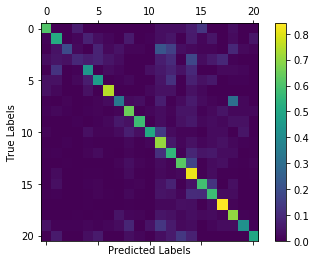

In [28]:
# Confusion Matrix for Uniform Model

uniform_confusion_matrix, category_encoder = create_confusion_matrix(valid_samples.label, uniform_predictions)
show_confusion_matrix(uniform_confusion_matrix)


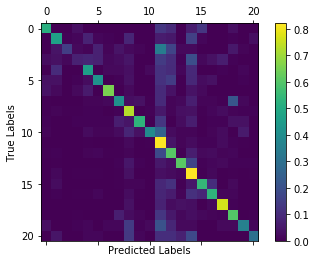

In [31]:
# Confusion Matrix for TF-IDF Model

tf_idf_confusion_matrix, category_encoder = create_confusion_matrix(samples.label, tf_idf_predictions)
show_confusion_matrix(tf_idf_confusion_matrix)

## Persist Models

In [32]:
torch.save(best_uniform_model.state_dict(), './models/uniform_glove_model.torch')
torch.save(best_tf_idf_model.state_dict(), './models/tf_idf_model.torch')
